#### Model building setup

Contains:
- DINOv2 frozen backbone loading
- pooling
- extraction of tabular data + images separately
- concatenation
- MLP structure
- (Frozen and unfrozen DINOv2 weights)


In [19]:
import torch

dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
#dino.eval()


Using cache found in C:\Users\julia/.cache\torch\hub\facebookresearch_dinov2_main


In [9]:
#freeze parameters
for p in dino.parameters():
    p.requires_grad = False


import os
print(os.getcwd())

c:\Users\julia\Documents\Image2Biomass_BME338


In [16]:
#Pre-process images
from torchvision.transforms import v2
import pandas as pd
import torch
import os
from PIL import Image

def preprocess(img_folder_rel_path,resize):
    transformer = v2.Compose([
        v2.Resize(size=resize),
        v2.ToImage(),
        v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean = [0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
        ])
    processed_images = []
    folder_path = os.path.join(img_folder_rel_path)
    folder_path = folder_path.replace("\\", "/")
    for file in os.listdir(folder_path):
        if file.lower().endswith("jpg"):
            img_path = os.path.join(folder_path,file)
            img = Image.open(img_path).convert("RGB")
            trans_img = transformer(img)
            processed_images.append(trans_img)
    print("Images processed")
    print(len(processed_images))
    return processed_images

processed_images = preprocess("data\\train",224)







    

Images processed
357


In [17]:
#stack the images 
img_batch = torch.stack(processed_images)


In [20]:
with torch.no_grad():  
    outputs = dino(img_batch)

In [23]:
print(outputs.shape)



torch.Size([357, 384])


In [24]:
import umap
import matplotlib.pyplot as plt

features = outputs.numpy()

reducer = umap.UMAP()
embedding = reducer.fit_transform(features)
embedding.shape


(357, 2)

Text(0, 0.5, 'UMAP2')

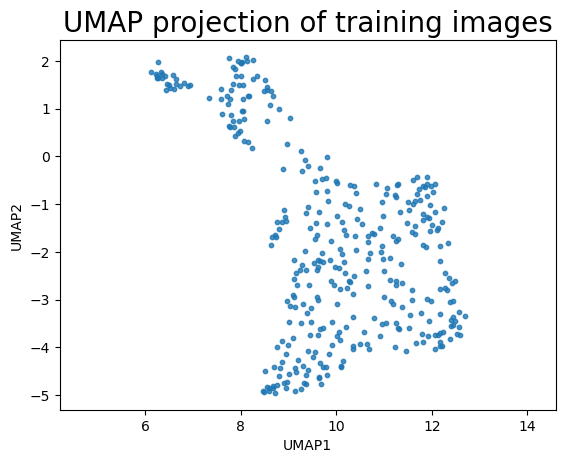

In [30]:
plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    s=10,
    alpha=0.8)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of training images', fontsize=20)
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")